# HarvestStat Data Profiling - Madagascar

In [1]:
from functools import reduce
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32739' # Madagascar
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/MG_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Madagascar',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1982	 | MG1982A1 | 6	| MG1982A2	| 29	| MG1982A3	| 110	|
| 2004	 | MG2004A1 | 6	| MG2004A2	| 22	| MG2004A3	| 111	|
| 2009	 | MG2009A1 | 6	| MG2009A2	| 22	| MG2009A3	| 119	|
----------------------------------------------- #


In [3]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_MG.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_MG.csv is saved.


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Remove admin-1 level data
rdx = df['fnid'].apply(lambda x: x[6:8]) == 'A1'
df = df[~rdx]
# Remove reporting units
df = df[df['fnid'] != 'MG1982R3010101']
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([MG_Admin3_1982, MG_Admin3_2004, MG_Admin3_2009, MG_Admin2_2009], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 72,908
Removed 24,753 "Missing Value" points
0/18,227 "Area Harvested" points are retained.
15,137/18,227 "Area Planted" points are retained.
18,051/18,227 "Quantity Produced" points are retained.
14,967/18,227 "Yield" points are retained.
Current data points: 48,155

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1987 - 2019
50 grain types are found: African oil palm nut, Artichoke, Bambara groundnut, Banana (unspecified), Barley (Unspecified), Beans (mixed), Beet, Broad Beans, Broccoli, Carrots, Cassava, Chili pepper (Unspecified), Clove, Cocoa, Coffee (unspecified), Cotton (Unspecified), Cowpea (unspecified), Cucumber, Eggplant, Fibers (unspecified), Fodder crop (unspecified), Garlic (fresh), Ginger, Green pea, Groundnuts (In Shell), Jute, Lentils, Lettuce (Unspecified), Maize (Corn), Millet, Onions, Other stem vegetables, Pepper (Piper spp.), Pi

- Madagascar crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-madagascar.png?itok=xj7JlAs0"  width=900><br>

<img src="https://www.arcgis.com/sharing/rest/content/items/7089db1e20d140d59f8db79afb0996ff/data"  width=900>

- FDW data consists of `MG1982A3`, `MG1982R3`, `MG2004A3`, and `MG2009A2`

| Year  | Admin-1  | # units  | Admin-2  | # units | Admin-3  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   | :----:   | :---:   |
| 1982	 | MG1982A1 | 6	| MG1982A2	| 29	| MG1982A3	| 110	|
| 2004	 | MG2004A1 | 6	| MG2004A2	| 22	| MG2004A3	| 111	|
| 2009	 | MG2009A1 | 6	| **`MG2009A2`**	| 22	| MG2009A3	| 119	|

- In 2004, 1 district is divided and added.

| 1982-2004 | 2004-2009 |
| :---:| :---:|
|Ambositra (MG1982A3030102) | Ambositra (MG2004A3030202), Manandriana (MG2004A3030204) |

- Comparison between admin boundaries.

<img src="../figures/MG_admin_shapes.png" width=900>

- In 2009, admin-level 3 data became admin-level 2 data.
- **`MG2009A2`** is used to represent the current admin-level 2 crop data.
- Madagascar has a single crop season: `Annual`.
- Madagascar has no population group(s).

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = MG_Admin2_2009.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# Manual change
idx = shape_used['FNID'].apply(lambda x: x[6:8] == 'A3')
shape_used.loc[idx, 'name'] = shape_used.loc[idx, 'ADMIN3']
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Aggregation to lower admin level -------------- #
# *We aggregate admin-3 data to admin-2 data
# Generate AdminLink manually
from tools import CreateLinkAdmin, invert_dicts
link_1982, _, _ = CreateLinkAdmin(MG_Admin2_2009, MG_Admin3_1982, old_on='ADMIN2', new_on='ADMIN3')
link_1982 = invert_dicts(link_1982)
link_2004, _, _ = CreateLinkAdmin(MG_Admin2_2009, MG_Admin3_2004, old_on='ADMIN2', new_on='ADMIN3')
link_2004 = invert_dicts(link_2004)
link_2009, _, _ = CreateLinkAdmin(MG_Admin2_2009, MG_Admin3_2009, old_on='ADMIN2', new_on='ADMIN3')
link_2009 = invert_dicts(link_2009)
assert link_1982.keys() == link_2004.keys() == link_2009.keys()
link = {}
for fnid in link_1982.keys():
    link[fnid] = [*link_1982[fnid], *link_2004[fnid], *link_2009[fnid]]
# Connect data with AdminLink
area_new = []
prod_new = []
for fnid in link.keys():
    area_merged = [area[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    area_merged = reduce(lambda a, b: a.add(b, fill_value=0), area_merged)
    area_merged.columns = area[fnid].columns
    area_merged = pd.concat([area_merged], keys=[fnid], names=['fnid'], axis=1)
    area_new.append(area_merged)
    prod_merged = [prod[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    prod_merged = reduce(lambda a, b: a.add(b, fill_value=0), prod_merged)
    prod_merged.columns = prod[fnid].columns
    prod_merged = pd.concat([prod_merged], keys=[fnid], names=['fnid'], axis=1)
    prod_new.append(prod_merged)
area_new = pd.concat(area_new, axis=1)
prod_new = pd.concat(prod_new, axis=1)
assert sum(abs((area_new.sum(1) - area.sum(1))/(area.sum(1) + 0.01)) > 0.01) == 0  # less than 1% difference is allowed
assert sum(abs((prod_new.sum(1) - prod.sum(1))/(prod.sum(1) + 0.01)) > 0.01) == 0  # less than 1% difference is allowed
# # ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# area_new.loc[2004,pd.IndexSlice['MG2009A20501',:,'Maize (Corn)','Annual',:]] = np.nan
# crop_new.loc[2004,pd.IndexSlice['MG2009A20501',:,'Maize (Corn)','Annual',:]] = np.nan
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [country, season_name] are in the external season calendar.


# Postprocessing outlier removal

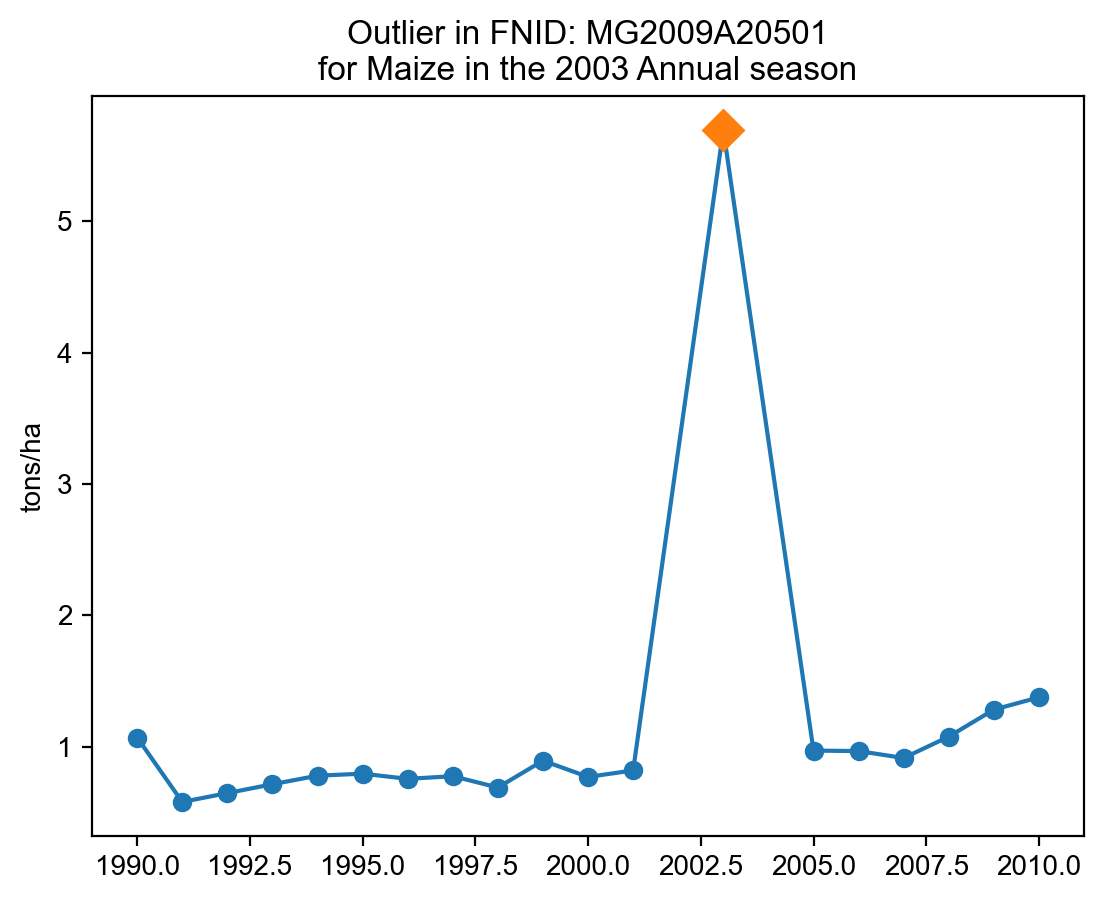

In [8]:
from matplotlib import pyplot as plt

outliers = [
    ['MG2009A20501','Maize','Annual',2003]
]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title('Outlier in FNID: '+iou[0]+'\nfor '+iou[1]+' in the '+str(iou[3])+' '+iou[2]+' season')
    plt.ylabel('tons/ha')
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1

In [9]:
# Save data
fn_out = '../data/crop/adm_crop_production_MG.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

../data/crop/adm_crop_production_MG.csv is saved.


# Visualization of production data

/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


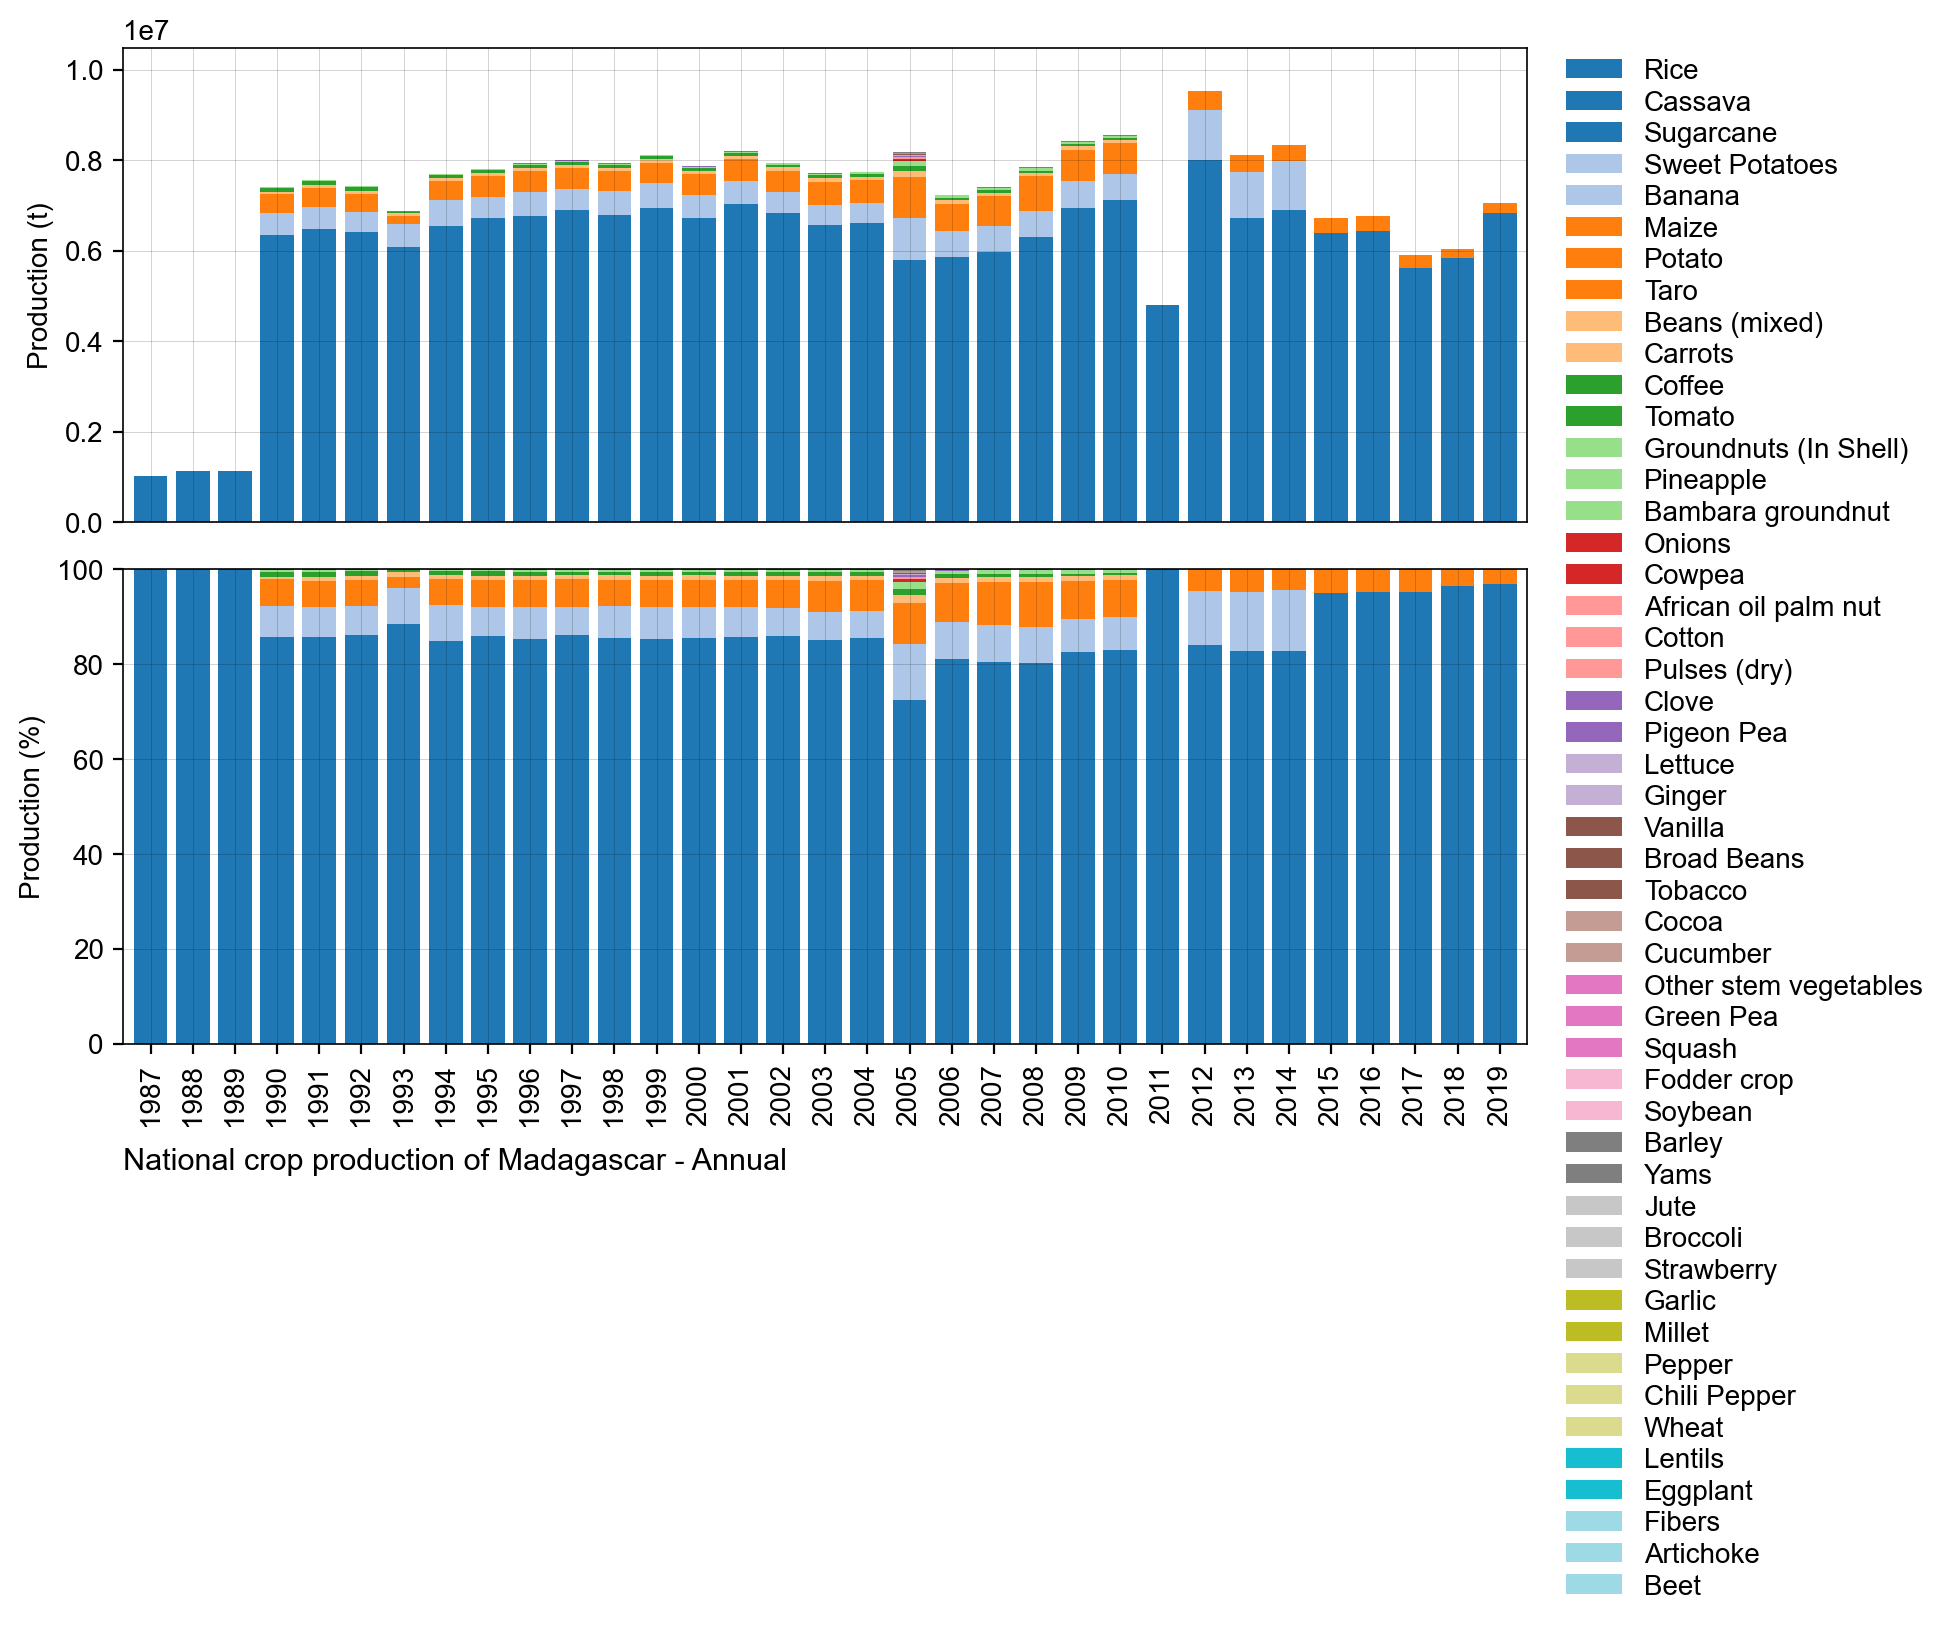

../figures/MG_bar_natgrainprod_Annual.png is saved.


In [10]:
# Bar chart of national crop production
country_iso, country_name = 'MG', 'Madagascar'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

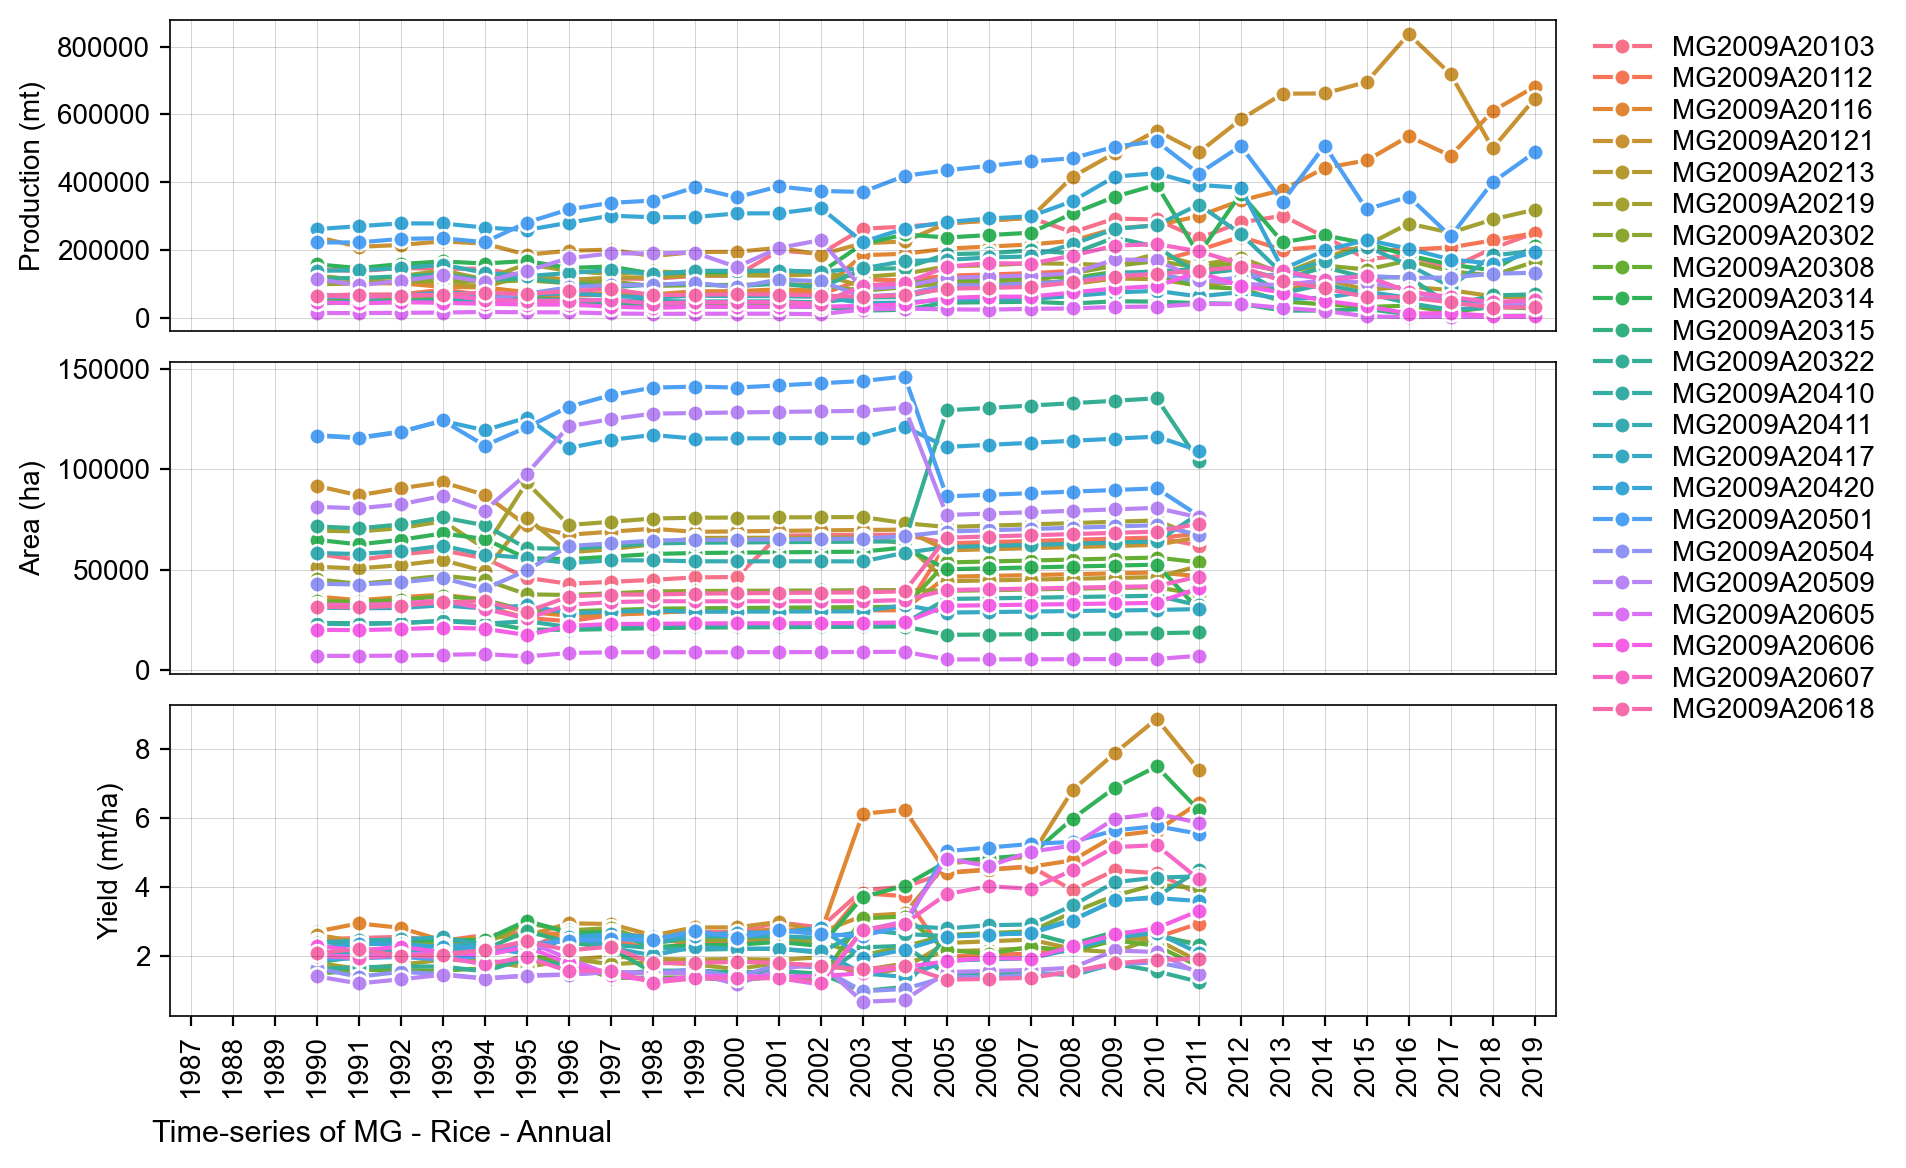

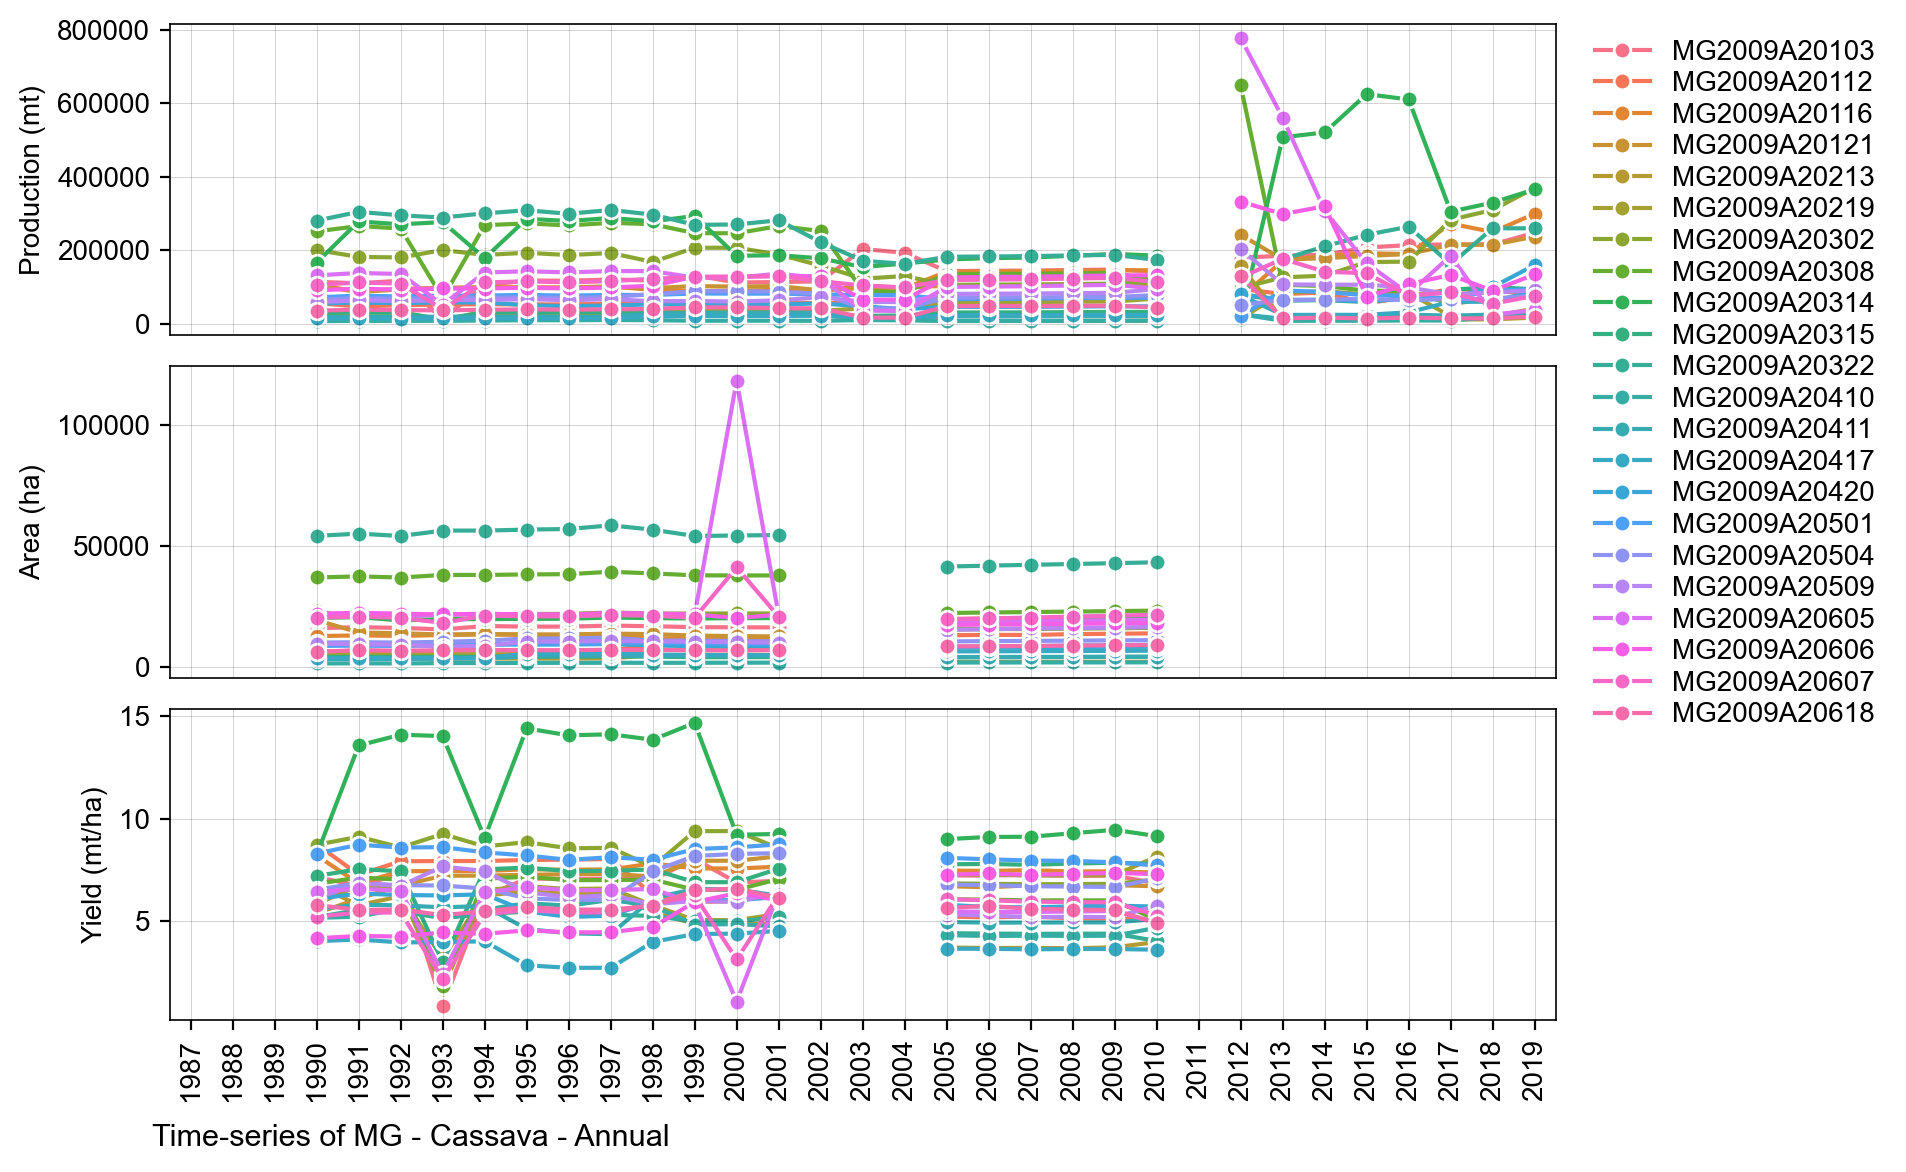

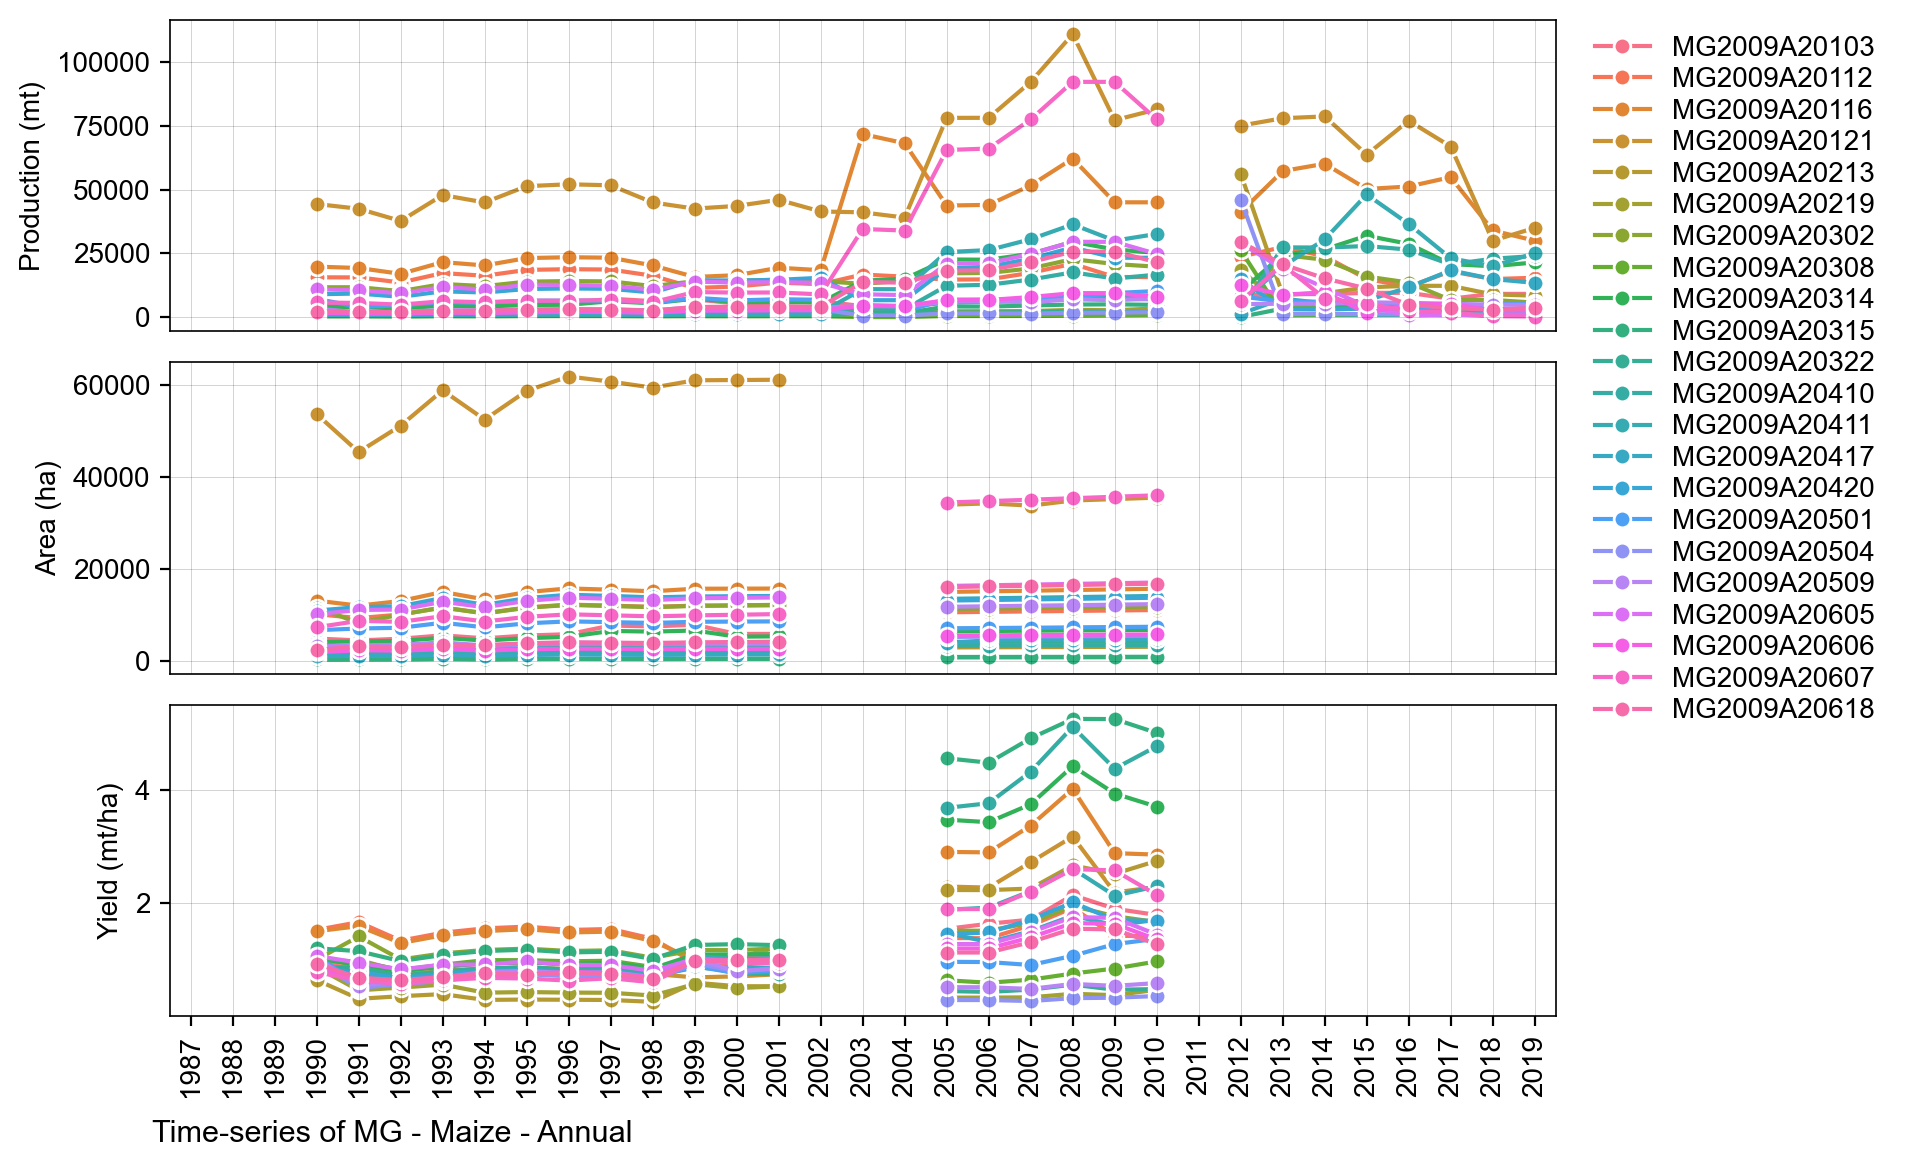

In [11]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'MG', 'Madagascar'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Rice','Annual'],
    ['Cassava','Annual'],
    ['Maize','Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)